In [1]:
import PIL
from glob import glob
%matplotlib inline
# Import libraries
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import numpy as np
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf

batch_size = 32
x_train1 = np.array([np.array(PIL.Image.open(filename).convert('RGB').resize([64,64])) for filename in glob('image/cage/*')])/255
x_train2 = np.array([np.array(PIL.Image.open(filename).convert('RGB').resize([64,64])) for filename in glob('image/trump/*')])/255
x_valid1 = x_train1[-batch_size:]
x_valid2 = x_train2[-batch_size:]
x_train1 = x_train1[:-batch_size]
x_train2 = x_train2[:-batch_size]
print(x_train1.shape)
print(x_train2.shape)

C:\Users\CGVLAB-02\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(286, 64, 64, 3)
(344, 64, 64, 3)


In [2]:
def plot_imgs(imgs, n, title=None):
    fig, axs = plt.subplots(1, n, figsize=(n, 2))
    if n==1:
        axs = [axs]
    for i in range(n):
        axs[i].imshow(imgs[i], cmap='gray')
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    if title is not None:
        fig.suptitle(title)
    plt.show()

In [3]:
class AutoEncoder(object):
    def __init__(self, image_size, lr=0.001, cost_function='bce', optimizer='adadelta'):
        
        self.image_size = image_size
        self.lr = lr # learning rate
        self.cost_function = cost_function
        self.optimizer = optimizer
        self.build_model()
        
    def build_model(self):
        image_size = self.image_size
        self.encoder_input1 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input1')
        self.encoder_input2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input2')
        self.decoder_output1 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='decoder_output1')
        self.decoder_output2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='decoder_output2')
        def encoder(encoder_input):
            with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
                # TODO: Complete encoder
                encoder_input = tf.reshape(encoder_input, [-1, 12288])
                hidden = tf.layers.dense(inputs=encoder_input, units=512, activation=tf.nn.relu)
                hidden = tf.layers.dense(hidden, units=256, activation=tf.nn.relu)
                hidden = tf.layers.dense(hidden, units=64, activation=tf.nn.relu)
                hidden = tf.layers.dense(hidden, units=16, activation=tf.nn.relu)
                
            return hidden
          
        self.encoded_embedding1 = encoder(self.encoder_input1)
        self.encoded_embedding2 = encoder(self.encoder_input2)
        
        def decoder(encoded_embedding, scope_name):   
            with tf.variable_scope(scope_name): 
                # TODO: Complete decoder 
                hidden = tf.layers.dense(inputs=encoded_embedding, units = 64, activation=tf.nn.relu)
                hidden = tf.layers.dense(inputs=hidden, units = 256, activation=tf.nn.relu)
                hidden = tf.layers.dense(inputs=hidden, units = 512, activation=tf.nn.relu)
                outputs = tf.layers.dense(inputs=hidden, units = 12288, name = 'recon_logits')
                outputs = tf.reshape(outputs, [-1, 64, 64, 3])
            return outputs
              
        outputs1 = decoder(self.encoded_embedding1, 'decoder1')
        outputs2 = decoder(self.encoded_embedding2, 'decoder2')
        
        ################## define cost function and optimizer ##################        
        if self.cost_function == 'mse':
            self.reconstruct_x1 = outputs1
            self.reconstruct_x2 = outputs2
            self.cost1 = tf.reduce_mean(tf.pow(self.decoder_output1-outputs1, 2))
            self.cost2 = tf.reduce_mean(tf.pow(self.decoder_output2-outputs2, 2))
        elif self.cost_function == 'bce':
            self.reconstruct_x1 = tf.nn.sigmoid(outputs1)
            self.reconstruct_x2 = tf.nn.sigmoid(outputs2)
            self.cost1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                            labels=self.decoder_output1, 
                                                            logits=outputs1))
            self.cost2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                            labels=self.decoder_output2, 
                                                            logits=outputs2))
        else:
            self.reconstruct_x1 = outputs1
            self.reconstruct_x2 = outputs2
            self.cost1 = tf.reduce_mean(tf.abs(self.decoder_output1-outputs1))
            self.cost2 = tf.reduce_mean(tf.abs(self.decoder_output2-outputs2))
            
        self.cost = self.cost1 + self.cost2    
        self.lr = tf.Variable(self.lr, trainable=False, name='learning_rate')
        if self.optimizer == 'adadelta':
            self.optimize_op = tf.train.AdadeltaOptimizer(self.lr).minimize(self.cost)
        elif self.optimizer == 'adam':
            self.optimize_op = tf.train.AdamOptimizer(self.lr, beta1=0.5).minimize(self.cost)
        elif self.optimizer == 'rmsprop':
            self.optimize_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.cost)
        else:
            raise NotImplementedError
            
    def train(self, sess, x_train1, x_train2, x_train1_output, x_train2_output, 
              x_valid1, x_valid2, x_valid1_output, x_valid2_output, n_epoch=200, batch_size=100, patience=5):
        t0 = time()
        train_costs_per_epoch = []
        valid_costs_per_epoch = []
        best_cost = np.inf
        counter = 0
        def iter_data(*data, **kwargs):
            size = kwargs.get('batch_size', 32)
            try:
                n = len(data[0])
            except:
                n = data[0].shape[0]
            batches = int(n / size)
            if n % size != 0:
                batches += 1

            for b in range(batches):
                start = b * size
                end = (b + 1) * size
                if end > n:
                    end = n
                if len(data) == 1:
                    yield data[0][start:end]
                else:
                    yield tuple([d[start:end] for d in data])
        for epoch in range(n_epoch):
            t = time()
            data_to_use = min(len(x_train1), len(x_train2))
            shuffle_idx = np.random.permutation(len(x_train1))
            x_train1 = x_train1[shuffle_idx][:data_to_use]
            x_train1_output = x_train1_output[shuffle_idx][:data_to_use]
            shuffle_idx = np.random.permutation(len(x_train2))
            x_train2 = x_train2[shuffle_idx][:data_to_use]
            x_train2_output = x_train2_output[shuffle_idx][:data_to_use]
            train_costs1 = []
            train_costs2 = []
            train_costs = []
            valid_costs1 = []
            valid_costs2 = []
            valid_costs = []
            
            # train
            for input1_batch, input2_batch, output1_batch, output2_batch in iter_data(x_train1, x_train2, x_train1_output, x_train2_output, batch_size=batch_size):
                feed_dict = {
                    self.encoder_input1: input1_batch, 
                    self.decoder_output1: output1_batch,
                    self.encoder_input2: input2_batch, 
                    self.decoder_output2: output2_batch,
                    self.lr: 5e-5,
                }
                _, cost1, cost2, cost = sess.run([self.optimize_op, self.cost1, self.cost2, self.cost], feed_dict=feed_dict)
                train_costs1.append(cost1)
                train_costs2.append(cost2)
                train_costs.append(cost)
            print('epoch{}, cost: {:.4f}, train_cost1: {:.4f}, train_cost2: {:.4f}, time_passed: {}'.format(
                   epoch, np.mean(train_costs), np.mean(train_costs1), np.mean(train_costs2), time()-t))
            train_costs_per_epoch.append(np.mean(train_costs))
            
            # validation
            for input1_batch, input2_batch, output1_batch, output2_batch in iter_data(x_valid1, x_valid2, x_valid1_output, x_valid2_output, batch_size=batch_size):
                feed_dict = {
                    self.encoder_input1: input1_batch, 
                    self.decoder_output1: output1_batch,
                    self.encoder_input2: input2_batch, 
                    self.decoder_output2: output2_batch,
                }
                cost1, cost2, cost = sess.run([self.cost1, self.cost2, self.cost], feed_dict=feed_dict)
                valid_costs1.append(cost1)
                valid_costs2.append(cost2)
                valid_costs.append(cost)
            print('epoch{}, valid_cost: {:.4f}, valid_cost1: {:.4f}, valid_cost2: {:.4f}, time_passed: {}'.format(
                   epoch, np.mean(valid_costs), np.mean(valid_costs1), np.mean(valid_costs2), time()-t))
            valid_costs_per_epoch.append(np.mean(valid_costs))
            
            # for every 50 epoch, plot image
            if epoch > 0 and epoch % 50 == 0:
                print('epoch: {}'.format(epoch))
                n = 10
                orig_imgs = x_train1[:n]
                recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
                min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(min_value < 0, recon_imgs-min_value, recon_imgs)
                max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)
                recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
                min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(min_value < 0, recon_imgs2-min_value, recon_imgs2)
                max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
                plot_imgs(orig_imgs, n=n, title='Test Samples')
                plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
                plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

                orig_imgs = x_train2[:n]
                recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
                min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(min_value < 0, recon_imgs-min_value, recon_imgs)
                max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)
                recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
                min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(min_value < 0, recon_imgs2-min_value, recon_imgs2)
                max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
                
            # early stop
            if best_cost > np.mean(valid_costs):
                best_cost = np.mean(valid_costs)
                counter = 0
            else:
                counter += 1
            if counter >= patience:
                print('early stop at {} epoch'.format(epoch))
                break
        return train_costs_per_epoch, valid_costs_per_epoch
            
    def encode(self, sess, inputs, use_decoder1=True):
        if use_decoder1:
            return sess.run(self.encoded_embedding1, feed_dict={self.encoder_input1: inputs})
        else:
            return sess.run(self.encoded_embedding2, feed_dict={self.encoder_input2: inputs})
          
    def reconstruct(self, sess, inputs, use_decoder1=True):
        if use_decoder1:
            return sess.run(self.reconstruct_x1, feed_dict={self.encoder_input1: inputs})
        else:
            return sess.run(self.reconstruct_x2, feed_dict={self.encoder_input2: inputs})

In [4]:
tf.reset_default_graph()
np.random.seed(123)
tf.set_random_seed(123)
autoencoder = AutoEncoder(image_size=64, optimizer='adam', lr=0.0001, cost_function='abs')

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

epoch0, cost: 0.8690, train_cost1: 0.4565, train_cost2: 0.4124, time_passed: 1.1728968620300293
epoch0, valid_cost: 0.7507, valid_cost1: 0.3853, valid_cost2: 0.3654, time_passed: 1.2107975482940674
epoch1, cost: 0.6354, train_cost1: 0.3359, train_cost2: 0.2994, time_passed: 1.1729183197021484
epoch1, valid_cost: 0.4885, valid_cost1: 0.2582, valid_cost2: 0.2303, time_passed: 1.2018427848815918
epoch2, cost: 0.4287, train_cost1: 0.2237, train_cost2: 0.2050, time_passed: 1.1559631824493408
epoch2, valid_cost: 0.3652, valid_cost1: 0.1940, valid_cost2: 0.1711, time_passed: 1.1848864555358887
epoch3, cost: 0.3488, train_cost1: 0.1780, train_cost2: 0.1708, time_passed: 1.1569621562957764
epoch3, valid_cost: 0.3311, valid_cost1: 0.1770, valid_cost2: 0.1541, time_passed: 1.188877820968628
epoch4, cost: 0.3298, train_cost1: 0.1666, train_cost2: 0.1632, time_passed: 1.1769094467163086
epoch4, valid_cost: 0.3246, valid_cost1: 0.1734, valid_cost2: 0.1512, time_passed: 1.2068309783935547
epoch5, cos

epoch42, cost: 0.2510, train_cost1: 0.1250, train_cost2: 0.1260, time_passed: 1.187880277633667
epoch42, valid_cost: 0.2714, valid_cost1: 0.1458, valid_cost2: 0.1256, time_passed: 1.2168049812316895
epoch43, cost: 0.2494, train_cost1: 0.1239, train_cost2: 0.1254, time_passed: 1.1988508701324463
epoch43, valid_cost: 0.2701, valid_cost1: 0.1444, valid_cost2: 0.1257, time_passed: 1.2297708988189697
epoch44, cost: 0.2486, train_cost1: 0.1235, train_cost2: 0.1251, time_passed: 1.1898739337921143
epoch44, valid_cost: 0.2697, valid_cost1: 0.1449, valid_cost2: 0.1249, time_passed: 1.2217905521392822
epoch45, cost: 0.2483, train_cost1: 0.1234, train_cost2: 0.1250, time_passed: 1.1599535942077637
epoch45, valid_cost: 0.2729, valid_cost1: 0.1466, valid_cost2: 0.1262, time_passed: 1.188877820968628
epoch46, cost: 0.2488, train_cost1: 0.1234, train_cost2: 0.1254, time_passed: 1.1709239482879639
epoch46, valid_cost: 0.2706, valid_cost1: 0.1447, valid_cost2: 0.1259, time_passed: 1.2048368453979492
ep

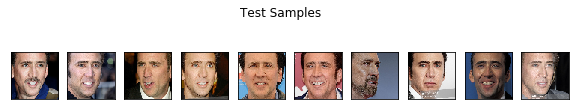

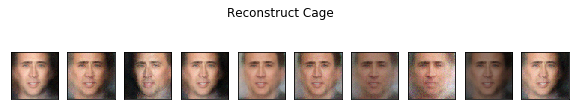

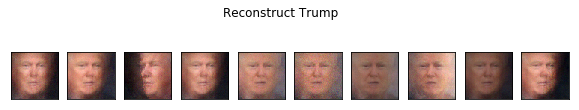

epoch51, cost: 0.2455, train_cost1: 0.1210, train_cost2: 0.1245, time_passed: 1.1739161014556885
epoch51, valid_cost: 0.2706, valid_cost1: 0.1439, valid_cost2: 0.1268, time_passed: 1.2048351764678955
epoch52, cost: 0.2460, train_cost1: 0.1210, train_cost2: 0.1250, time_passed: 1.211817979812622
epoch52, valid_cost: 0.2687, valid_cost1: 0.1437, valid_cost2: 0.1249, time_passed: 1.2417397499084473
epoch53, cost: 0.2448, train_cost1: 0.1202, train_cost2: 0.1245, time_passed: 1.1818952560424805
epoch53, valid_cost: 0.2680, valid_cost1: 0.1428, valid_cost2: 0.1252, time_passed: 1.2118172645568848
epoch54, cost: 0.2436, train_cost1: 0.1194, train_cost2: 0.1242, time_passed: 1.1948628425598145
epoch54, valid_cost: 0.2693, valid_cost1: 0.1434, valid_cost2: 0.1259, time_passed: 1.2267789840698242
epoch55, cost: 0.2437, train_cost1: 0.1194, train_cost2: 0.1243, time_passed: 1.1868820190429688
epoch55, valid_cost: 0.2679, valid_cost1: 0.1430, valid_cost2: 0.1249, time_passed: 1.2178010940551758
e

epoch93, cost: 0.2251, train_cost1: 0.1072, train_cost2: 0.1179, time_passed: 1.203838586807251
epoch93, valid_cost: 0.2574, valid_cost1: 0.1361, valid_cost2: 0.1213, time_passed: 1.2327628135681152
epoch94, cost: 0.2248, train_cost1: 0.1072, train_cost2: 0.1176, time_passed: 1.1659374237060547
epoch94, valid_cost: 0.2577, valid_cost1: 0.1363, valid_cost2: 0.1213, time_passed: 1.194861888885498
epoch95, cost: 0.2244, train_cost1: 0.1069, train_cost2: 0.1175, time_passed: 1.1769099235534668
epoch95, valid_cost: 0.2570, valid_cost1: 0.1358, valid_cost2: 0.1212, time_passed: 1.2078282833099365
epoch96, cost: 0.2240, train_cost1: 0.1067, train_cost2: 0.1173, time_passed: 1.1828932762145996
epoch96, valid_cost: 0.2564, valid_cost1: 0.1354, valid_cost2: 0.1210, time_passed: 1.212815284729004
epoch97, cost: 0.2246, train_cost1: 0.1070, train_cost2: 0.1176, time_passed: 1.1868822574615479
epoch97, valid_cost: 0.2565, valid_cost1: 0.1354, valid_cost2: 0.1212, time_passed: 1.216804027557373
epoc

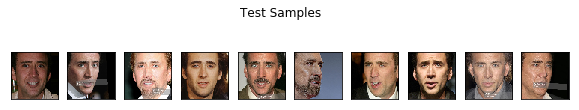

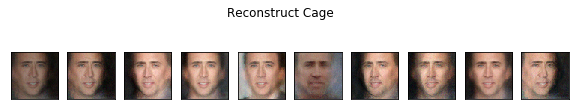

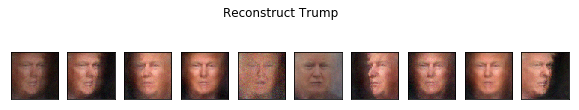

epoch101, cost: 0.2236, train_cost1: 0.1068, train_cost2: 0.1168, time_passed: 1.1489818096160889
epoch101, valid_cost: 0.2588, valid_cost1: 0.1364, valid_cost2: 0.1224, time_passed: 1.178903579711914
epoch102, cost: 0.2218, train_cost1: 0.1058, train_cost2: 0.1160, time_passed: 1.1599528789520264
epoch102, valid_cost: 0.2551, valid_cost1: 0.1353, valid_cost2: 0.1199, time_passed: 1.1888775825500488
epoch103, cost: 0.2210, train_cost1: 0.1055, train_cost2: 0.1155, time_passed: 1.1679320335388184
epoch103, valid_cost: 0.2578, valid_cost1: 0.1364, valid_cost2: 0.1214, time_passed: 1.1978552341461182
epoch104, cost: 0.2222, train_cost1: 0.1062, train_cost2: 0.1160, time_passed: 1.1799001693725586
epoch104, valid_cost: 0.2550, valid_cost1: 0.1349, valid_cost2: 0.1200, time_passed: 1.2088241577148438
epoch105, cost: 0.2215, train_cost1: 0.1060, train_cost2: 0.1155, time_passed: 1.164940595626831
epoch105, valid_cost: 0.2544, valid_cost1: 0.1353, valid_cost2: 0.1191, time_passed: 1.195860385

epoch142, cost: 0.2081, train_cost1: 0.0994, train_cost2: 0.1087, time_passed: 1.2088251113891602
epoch142, valid_cost: 0.2470, valid_cost1: 0.1322, valid_cost2: 0.1147, time_passed: 1.2397441864013672
epoch143, cost: 0.2080, train_cost1: 0.0994, train_cost2: 0.1086, time_passed: 1.2018437385559082
epoch143, valid_cost: 0.2468, valid_cost1: 0.1319, valid_cost2: 0.1149, time_passed: 1.2327630519866943
epoch144, cost: 0.2088, train_cost1: 0.0997, train_cost2: 0.1091, time_passed: 1.2088255882263184
epoch144, valid_cost: 0.2462, valid_cost1: 0.1317, valid_cost2: 0.1145, time_passed: 1.2397444248199463
epoch145, cost: 0.2074, train_cost1: 0.0990, train_cost2: 0.1084, time_passed: 1.1858854293823242
epoch145, valid_cost: 0.2472, valid_cost1: 0.1319, valid_cost2: 0.1153, time_passed: 1.215806245803833
epoch146, cost: 0.2090, train_cost1: 0.1001, train_cost2: 0.1090, time_passed: 1.1948623657226562
epoch146, valid_cost: 0.2484, valid_cost1: 0.1322, valid_cost2: 0.1162, time_passed: 1.22677826

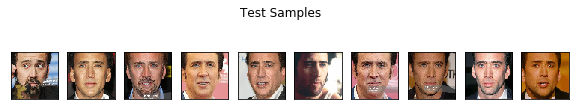

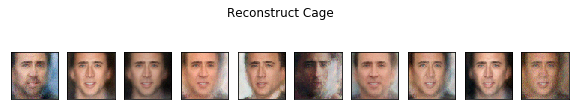

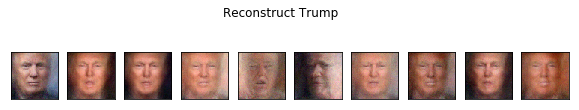

epoch151, cost: 0.2067, train_cost1: 0.0987, train_cost2: 0.1080, time_passed: 1.1789021492004395
epoch151, valid_cost: 0.2461, valid_cost1: 0.1319, valid_cost2: 0.1142, time_passed: 1.2108192443847656
epoch152, cost: 0.2069, train_cost1: 0.0988, train_cost2: 0.1081, time_passed: 1.193864107131958
epoch152, valid_cost: 0.2470, valid_cost1: 0.1316, valid_cost2: 0.1154, time_passed: 1.2257804870605469
epoch153, cost: 0.2067, train_cost1: 0.0987, train_cost2: 0.1080, time_passed: 1.2118175029754639
epoch153, valid_cost: 0.2437, valid_cost1: 0.1307, valid_cost2: 0.1130, time_passed: 1.24273681640625
epoch154, cost: 0.2052, train_cost1: 0.0979, train_cost2: 0.1073, time_passed: 1.20084547996521
epoch154, valid_cost: 0.2454, valid_cost1: 0.1310, valid_cost2: 0.1143, time_passed: 1.2317655086517334
epoch155, cost: 0.2051, train_cost1: 0.0978, train_cost2: 0.1073, time_passed: 1.2626831531524658
epoch155, valid_cost: 0.2466, valid_cost1: 0.1313, valid_cost2: 0.1154, time_passed: 1.299587011337

epoch192, cost: 0.1985, train_cost1: 0.0942, train_cost2: 0.1043, time_passed: 1.1749145984649658
epoch192, valid_cost: 0.2405, valid_cost1: 0.1292, valid_cost2: 0.1113, time_passed: 1.204836130142212
epoch193, cost: 0.1973, train_cost1: 0.0936, train_cost2: 0.1038, time_passed: 1.2068305015563965
epoch193, valid_cost: 0.2410, valid_cost1: 0.1290, valid_cost2: 0.1120, time_passed: 1.2357542514801025
epoch194, cost: 0.1981, train_cost1: 0.0940, train_cost2: 0.1041, time_passed: 1.182892084121704
epoch194, valid_cost: 0.2397, valid_cost1: 0.1286, valid_cost2: 0.1111, time_passed: 1.2158057689666748
epoch195, cost: 0.1976, train_cost1: 0.0937, train_cost2: 0.1038, time_passed: 1.1898763179779053
epoch195, valid_cost: 0.2414, valid_cost1: 0.1293, valid_cost2: 0.1121, time_passed: 1.219796895980835
epoch196, cost: 0.1977, train_cost1: 0.0938, train_cost2: 0.1040, time_passed: 1.2038383483886719
epoch196, valid_cost: 0.2406, valid_cost1: 0.1295, valid_cost2: 0.1111, time_passed: 1.2347579002

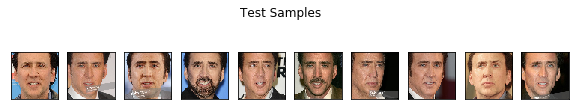

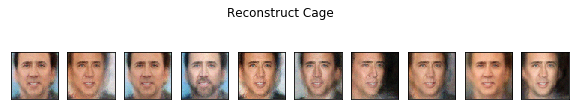

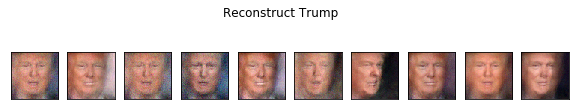

epoch201, cost: 0.1968, train_cost1: 0.0934, train_cost2: 0.1034, time_passed: 1.1998493671417236
epoch201, valid_cost: 0.2414, valid_cost1: 0.1295, valid_cost2: 0.1119, time_passed: 1.2297704219818115
epoch202, cost: 0.1978, train_cost1: 0.0939, train_cost2: 0.1039, time_passed: 1.2038373947143555
epoch202, valid_cost: 0.2412, valid_cost1: 0.1293, valid_cost2: 0.1119, time_passed: 1.2367513179779053
epoch203, cost: 0.1976, train_cost1: 0.0938, train_cost2: 0.1038, time_passed: 1.2357544898986816
epoch203, valid_cost: 0.2407, valid_cost1: 0.1289, valid_cost2: 0.1118, time_passed: 1.2666728496551514
epoch204, cost: 0.1971, train_cost1: 0.0935, train_cost2: 0.1036, time_passed: 1.2716608047485352
epoch204, valid_cost: 0.2406, valid_cost1: 0.1285, valid_cost2: 0.1121, time_passed: 1.303577184677124
epoch205, cost: 0.1973, train_cost1: 0.0937, train_cost2: 0.1037, time_passed: 1.2437336444854736
epoch205, valid_cost: 0.2409, valid_cost1: 0.1287, valid_cost2: 0.1121, time_passed: 1.27465271

In [5]:
train_costs_per_epoch = autoencoder.train(sess, x_train1, x_train2, x_train1, x_train2, 
                                          x_valid1, x_valid2, x_valid1, x_valid2, n_epoch=1000, batch_size=batch_size, patience=20)

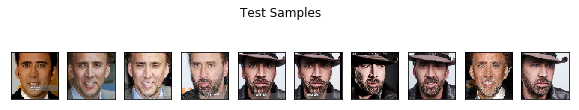

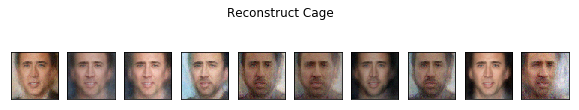

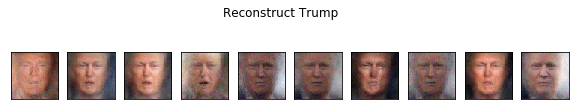

In [6]:
n = 10
orig_imgs = x_valid1[:n]

recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(min_value < 0, recon_imgs - min_value, recon_imgs)
max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)

recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(min_value < 0, recon_imgs2 - min_value, recon_imgs2)
max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
    
plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

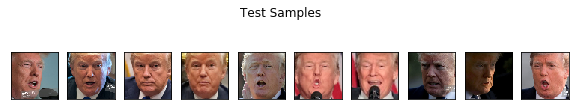

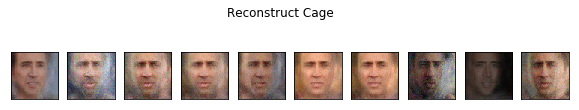

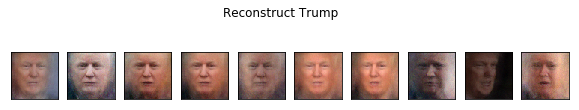

In [7]:
n = 10
orig_imgs = x_valid2[:n]

recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(min_value < 0, recon_imgs - min_value, recon_imgs)
max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)

recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(min_value < 0, recon_imgs2 - min_value, recon_imgs2)
max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

## What we learn ?

we learn how the architecture of autoencoder and how to use autoencoder

## Application

### Natural Language Preprosessing
1. word embedding

Word embedding represents word into vector and sometimes it uses autoencoder to make the representation more useful( other than usung one-hot encoder). For example, in the paper "The Sum of Its Parts": Joint Learning of Word and Phrase Representations with Autoencoders, it uses autoencoders to jointly learn representations for words and phrases.

url: https://arxiv.org/pdf/1506.05703.pdf
![](https://i.imgur.com/aYFMVP6.png)

### Document Cluster

Document classification is the problem of assigning documents to categories which needs to produce vectors to represent the document and autoencoder helps to beat the standard method of latent semntic analysis.
![](https://i.imgur.com/ml2BwkU.png)